# Prediction Pipeline

## Load model architecture
Architecture must be identical to the one used to create the weights. However, you can fix the trained layers and add new layers to accommodate new problems; see https://www.biorxiv.org/content/10.1101/2021.06.26.449864v1.full

In [ ]:
! mamba install -y -c plotly plotly

In [1]:
from keras.models import load_model
model=load_model('data/model/gtex/manual/gtex_model.h5')
print("Saved model summary:")
model.summary()

2022-07-23 17:23:01.223652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-23 17:23:01.250406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-23 17:23:01.251028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-23 17:23:01.252204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild Tenso

Saved model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 1000)              18964000  
_________________________________________________________________
1_decoder_batch_norm (BatchN (None, 1000)              4000      
_________________________________________________________________
1_activation (Activation)    (None, 1000)              0         
_________________________________________________________________
1_hidden_dropout (Dropout)   (None, 1000)              0         
_________________________________________________________________
output (Dense)               (None, 26)                26026     
Total params: 18,994,026
Trainable params: 18,992,026
Non-trainable params: 2,000
_________________________________________________________________


In [2]:
#load weights from last best checkpoint
model.load_weights("data/model/gtex")

2022-07-23 17:23:02.259555: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open data/model/gtex: Failed precondition: data/model/gtex; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


# Load and set up data
Make predictions on all the original, unshuffled training data to see which IDs are incorrectly predicted. 

In [3]:
# only use about 100 samples of each class:
SAMPLE_COUNT_THRESHOLD=100
from sbr.preprocessing import gtex
X, y, class_names, label_df = gtex.dataset_setup(sample_count_threshold = SAMPLE_COUNT_THRESHOLD,
                                          drop_classes_list = ['Bone Marrow', 'Fallopian Tube', 'Cervix Uteri', 'Bladder','Skin'])

Drop under-represented classes with less than 100 samples:
dropped Kidney
dropped Cervix Uteri
dropped Fallopian Tube
dropped Bladder
Counts per class:
(total number of samples, total number of genes) = 
(17244, 18966)
[ 0] Adipose Tissue	1204 samples
[ 1] Muscle      	 803 samples
[ 2] Blood Vessel	1335 samples
[ 3] Heart       	 861 samples
[ 4] Uterus      	 142 samples
[ 5] Vagina      	 156 samples
[ 6] Breast      	 459 samples
[ 7] Skin        	1809 samples
[ 8] Salivary Gland	 162 samples
[ 9] Brain       	2642 samples
[10] Adrenal Gland	 258 samples
[11] Thyroid     	 653 samples
[12] Lung        	 578 samples
[13] Spleen      	 241 samples
[14] Pancreas    	 328 samples
[15] Esophagus   	1445 samples
[16] Stomach     	 359 samples
[17] Colon       	 779 samples
[18] Small Intestine	 187 samples
[19] Prostate    	 245 samples
[20] Testis      	 361 samples
[21] Nerve       	 619 samples
[22] Blood       	 929 samples
[23] Pituitary   	 283 samples
[24] Ovary       	 180 sample

In [4]:
X.shape,y.shape

((17244, 18963), TensorShape([17244, 26]))

# Predict and assess mislabeled data

In [15]:
# (add confusion matrix here)

In [5]:
import pandas as pd
from sbr.evaluate import mislabeled_pair_counts
mislabeled_counts, mislabeled = mislabeled_pair_counts(model=model, X=X, y=y, class_names=class_names, 
                                                       sample_ids = pd.Series(label_df["sample_id"]),
                                                       batch_size=500)
mislabeled_counts

2022-07-23 17:23:14.116487: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-23 17:23:16.058260: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


counts
observed        predicted              
Adipose Tissue  Breast                6
                Colon                 2
                Skin                  1
Blood Vessel    Adipose Tissue       13
                Heart                 3
                Muscle                1
                Skin                  1
Brain           Lung                  1
Breast          Colon                 1
                Salivary Gland        1
                Adipose Tissue       49
Colon           Small Intestine      12
                Stomach               3
Esophagus       Adipose Tissue        4
                Blood Vessel          4
                Colon                 2
                Nerve                 3
                Salivary Gland        1
                Stomach               3
Heart           Adipose Tissue        1
Lung            Heart                 1
Ovary           Uterus                2
Pituitary       Brain                 1
Prostate        Colon                 1
Salivary Gland  Esophagus             8
Skin            Adipose Tissue        3
                Muscle                1
Small Intestine Adipose Tissue        1
                Colon                 2
Stomach         Esophagus             3
                Small Intestine       1
                Adipose Tissue        1
                Colon                 3
Thyroid         Blood Vessel          2
                Salivary Gland        1
Uterus          Blood Vessel          1
                Ovary                 1
Vagina          Skin                  1
                Colon                 1
                Nerve                 2
                Ovary                 4
                Prostate              1
                Uterus                4

# Plot class that has a single mislabel
The "Lung" class had 1 incorrect prediction. A "Lung" sample was incorrectly labeled as "Heart". To gain insight around the mislabel, plot the "Lung" principal components against "Heart" principal components and annotate the PCA plot with the sample that was mislabeled by the neural network|.

In [12]:
observed_class="Lung"
predicted_class="Heart"

In [13]:
m=mislabeled.reset_index()
m[m['observed']==observed_class]

,index,sample_id,predicted,observed
75,178,GTEX-1ICLY-0926-SM-CM2RJ,Heart,Lung


In [14]:
idx = mislabeled[mislabeled['observed']==observed_class]["sample_id"].iloc[0]

In [10]:
import gzip
import numpy as np
import pandas as pd
import os
import pathlib
from sklearn.decomposition import PCA

CLASS_NAMES=[observed_class,predicted_class]
USE_PYPLOT=True
NUM_PCS=3
MAX_SAMPS=200000

# read data
def read_from_raw(classes_to_read):
    attr_path = 'dist/gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt'
    attr_df = pd.read_table(attr_path)

    expr_df = pd.read_feather("data/gtex/expr.ftr")
    expr_df.reset_index(drop=True)
    expr_df=expr_df.set_index('sample_id')
    expr_df.index.name="SAMPID"
    expr_df.reset_index(inplace=True)

    expr_df=pd.merge(expr_df,attr_df[["SAMPID","SMTS"]])

    expr_df=expr_df.set_index('SAMPID')
    cols = expr_df.columns
    cols =cols[-1:].append(cols[:-1])
    expr_df=expr_df[cols]
    expr_df =expr_df[(expr_df['SMTS']==classes_to_read[0]) | (expr_df['SMTS']==classes_to_read[1])]

    return expr_df

df=read_from_raw(CLASS_NAMES)

# compute PCs
pca = PCA()
components = pca.fit_transform(df.iloc[:,1:])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
pc1,pc2,pc3 = components[df.reset_index()[df.reset_index()['SAMPID'] ==  idx ].index][0][0:3]


# Visualize the mislabeled point with PCA
Every dot on the PC1,PC2,PC3 plot below was correctly labeled with only one exception. Notice the points that are correctly predicted, despite clustering together with the incorrect class, per PCA. This is likely explained by PCA's difficulty with discerning non-linear relationships, with which neural nets excel.

In [11]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import plotly.express as px
import plotly.graph_objects as go
var = pca.explained_variance_ratio_.sum()
fig = go.Figure()
fig = px.scatter_3d(components, x=0, y=1, z=2, color=df['SMTS'],
                    title=f'Total Explained Variance: {var}',
                    labels={'0':'PC1', '1':'PC2', '2':'PC3'}
                   )
fig.update_layout(
    scene=dict(
        xaxis=dict(type="linear"),
        yaxis=dict(type="linear"),
        zaxis=dict(type="linear"),
        annotations=[
        dict(
            showarrow=True,
            x=pc1,
            y=pc2,
            z=pc3,
            text=f"Mislabeled as {observed_class}",
            xanchor="left",
            xshift=0,
            opacity=0.7)
         ]
    ),
)
'''
temp1 = fig.data[0].hovertemplate
fig.update_traces(hovertemplate = temp1 + '<br>' + "Category: %{customdata[0]}")

fig.add_annotation(x=pc1, y=pc2, z=pc3,
            text="Mislabeled as Blood Vessel",
            showarrow=True,
            arrowhead=1)
'''
fig.update_traces( marker={'size':2})
fig.show()

# 3D PCA scatter plot
Three views intothe interactive plot from the source-code controlled run follow; subsequent runs may have slightly different misclassifications, and may not have the prostate mislabelling. However, in this run, a single sample from all the red and blue samples was mislabeled, as annotated. The PCA indicates 1.0 variation is explained by the three principal components, despite some samples residing well outside their neighborhood. Nevertheless, every sample (plot data point) but one was correctly labeled as either colon or prostate by the neural network.  
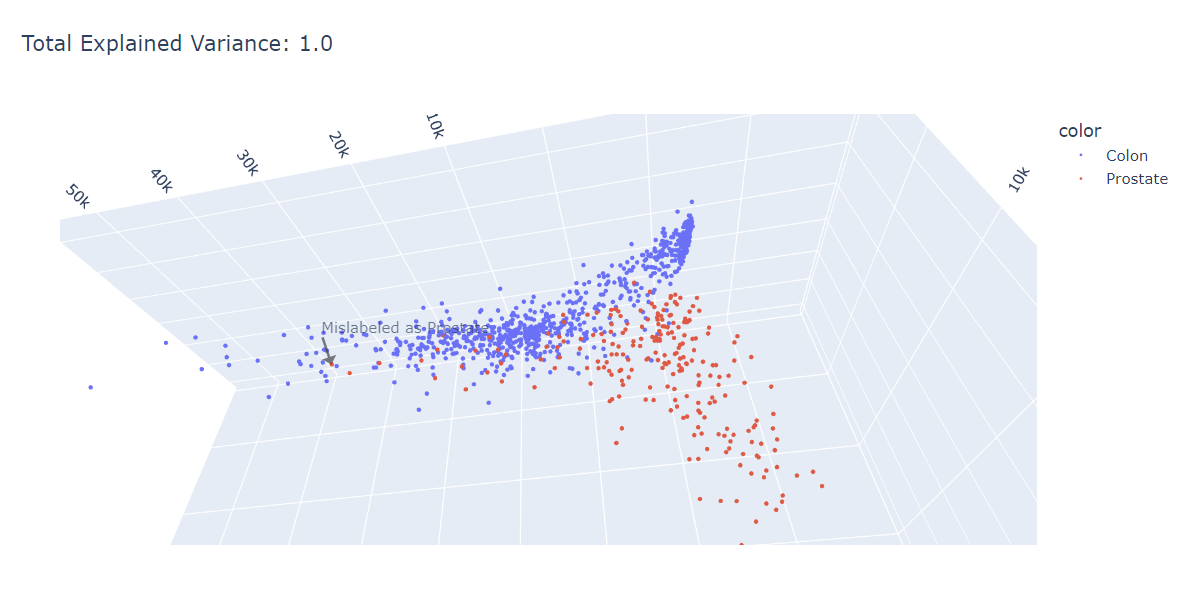
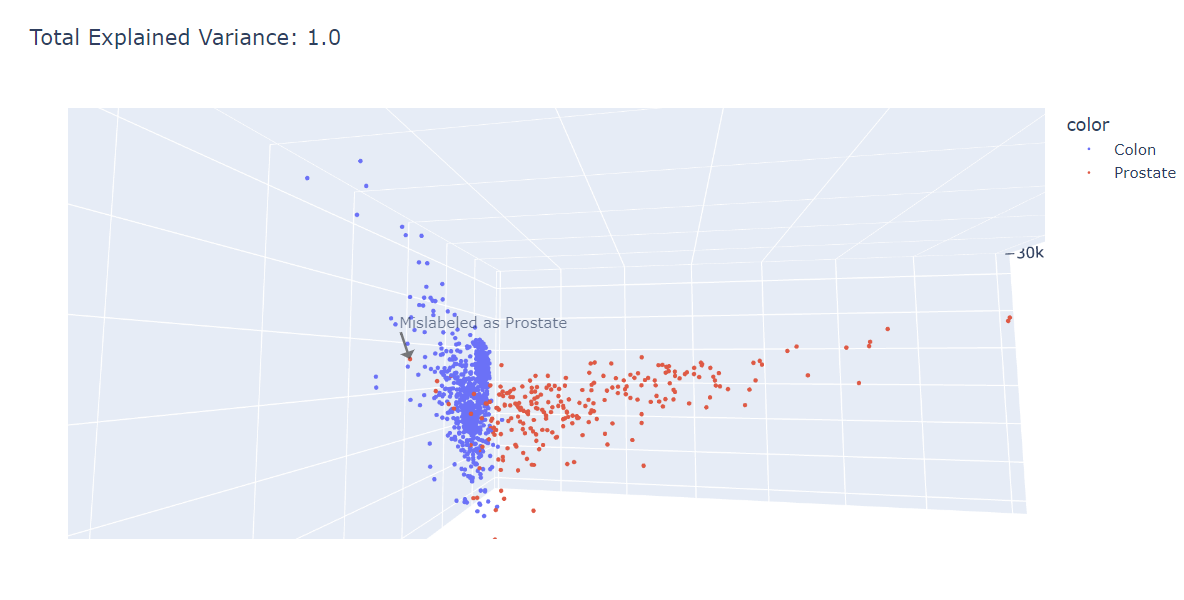
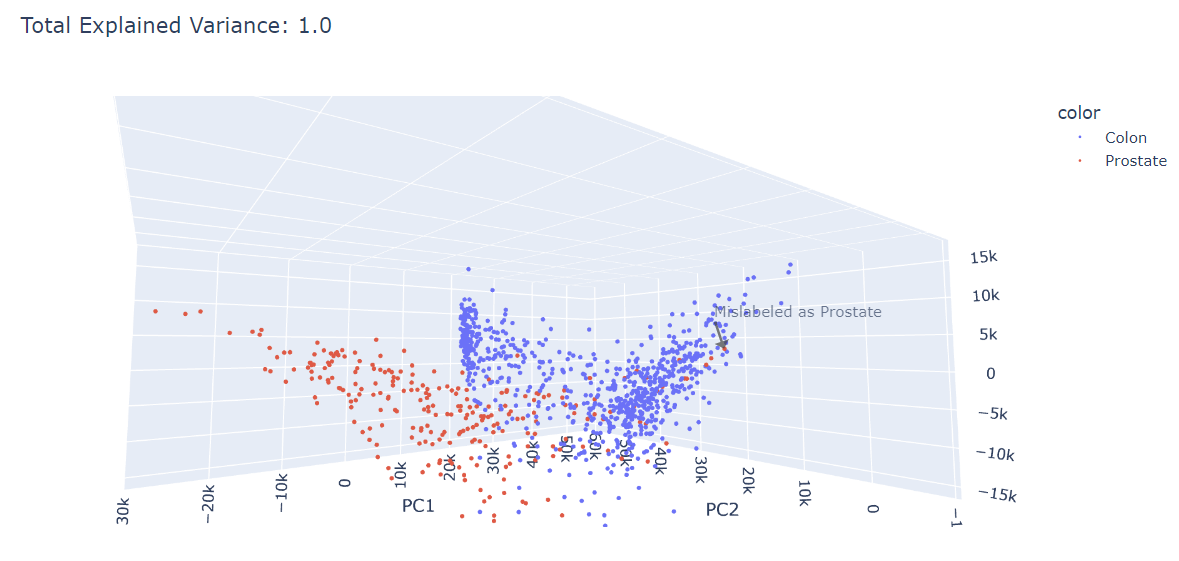

# Results from PCA scatter plot and Neural Network indicate candidate to investigate for sample swap in GTEx
Heart and lung tissue are biologically and biomolecularly distinct, which is reflected by this PCA that explains 1.00 of the variance. However, a sample labeled as Lung clusters well with Heart samples, and also was the only Lung sample mislabeled by our neural net. Since the neural net and the PCA both indicate this sample expresses more like Heart than like Lung, it may be worth retesting sampe GTEX-1ICLY-0926-SM-CM2RJ.
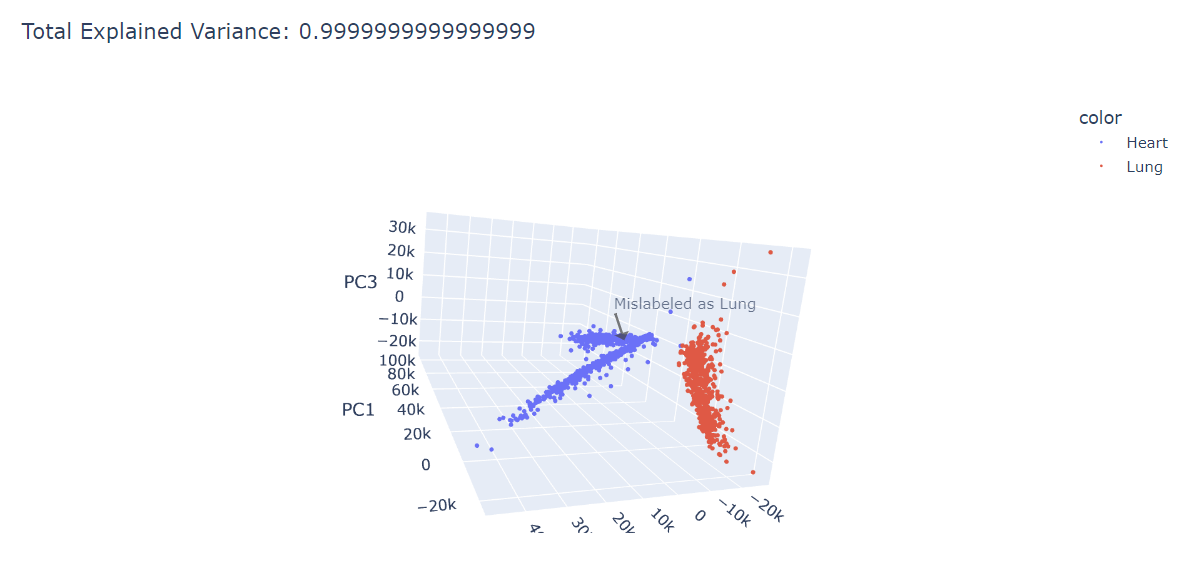
